In [127]:
import tarfile,sys
import pandas as pd
import os
import simplejson
import re as regex
import numpy as np

## Read from CSV file containing features

In [128]:
traindata = pd.read_csv('train-small')
traindata

,Unnamed: 0,class,user_name,id,tweet,avgsentiment,favorite_count,firstperson,geo,possibly_sensitive,retweet_count,retweeted,tsugawa,number_of_uppercase,number_of_exclamation,number_of_question,number_of_ellipsis
0,0,depression,k1Tgty92JWM,6195046850825297023,"RT @FpJgkXU6: My cat is sad because, having be...",0.112638,0,2670,NaN,0.0,249,False,0.0,48,0,0,0
1,0,control,f8Da_Rvi,8522289883066978092,Running Boston for Children's Hospital again. ...,0.118159,0,142,NaN,0.0,1,False,0.0,27,0,0,0
2,0,depression,hehQgSVVRpv,322688550056773303,My mom is just swell like that. :)####In other...,0.047492,0,2562,NaN,NaN,0,False,0.0,11,1,0,0
3,0,control,qPQRyK39gnG,2184602040112857282,Ain't nothing like starting your morning with ...,0.099925,0,2592,NaN,NaN,0,False,0.0,24,7,0,0
4,0,depression,j_1H5RgR2_6,2834216959061162834,RT @GAndbcDpitkbVU: #ThePinkPrintCoverTomorrow...,0.211423,0,2891,NaN,NaN,10,False,0.0,22,7,0,0
5,0,control,vlwXqvDcXHd8vR,2835019316888866733,RT @hdoQYECq: Dzhokhar Tsarnaev landed the cov...,0.138308,0,496,NaN,NaN,959,False,0.0,41,0,0,0
6,0,depression,oTz15zT,3959835890448092091,Today #AtTheMovies the clips come from my daug...,0.278740,0,1375,NaN,NaN,0,False,0.0,21,0,0,0
7,0,control,i_y79Pl4VIi7k,5666978709914902022,The Cross Keys Endell St Dutty Dutty London ht...,0.078549,0,453,NaN,0.0,0,False,0.0,27,0,0,0
8,0,depression,xGzqP93lsEjiaG,1578519607921696117,"AND TEEEELLLLL ME WE BELONG TOGETHERRRE####""No...",0.066448,0,2058,NaN,NaN,0,False,0.0,39,3,0,0
9,0,control,gHgnIT,4042618482248831958,@lUnvYAewx3J Thanks haha! http://t.co/ilF1VFy4...,0.017524,3,2145,NaN,0.0,2,False,0.0,23,4,0,0


## Separate each tweet in its own row

In [129]:
b = pd.DataFrame(traindata['tweet'].str.split('####').tolist(), index=[traindata['user_name'], traindata['class']]).stack()
b = b.reset_index()[[0, 'user_name','class']] # var1 variable is currently labeled 0
b.columns = ['tweet', 'user_name','class'] # renaming var1
final_train_data = b

## Clean Up data

In [130]:
def remove_by_regex(tweets, regexp):
    tweets.loc[:, "tweet"].replace(regexp, "", inplace=True)
    return tweets

def remove_urls(tweets):
    return remove_by_regex(tweets, regex.compile(r"http.?://[^\s]+[\s]?"))

def remove_na(tweets):
    return tweets[tweets["tweet"] != "Not Available"]

def remove_special_chars(tweets):  # it unrolls the hashtags to normal words
    for remove in map(lambda r: regex.compile(regex.escape(r)), [",", ":", "\"", "=", "&", ";", "%", "$",
                                                                 "@", "%", "^", "*", "(", ")", "{", "}",
                                                                 "[", "]", "|", "/", "\\", ">", "<", "-",
                                                                 "!", "?", ".", "'",
                                                                 "--", "---", "#"]):
        tweets.loc[:, "tweet"].replace(remove, "", inplace=True)
    return tweets

def remove_usernames(tweets):
    return remove_by_regex(tweets, regex.compile(r"@[^\s]+[\s]?"))

def remove_numbers(tweets):
    return remove_by_regex(tweets, regex.compile(r"\s?[0-9]+\.?[0-9]*"))

In [131]:
data = final_train_data
data = remove_urls(data)
data = remove_na(data)
data = remove_usernames(data)
data = remove_special_chars(data)
data = remove_numbers(data)

## Remove empty tweets or tweets with one word

In [132]:
x = data.query('tweet != ""')
x.shape
data=x
data = data[data.tweet.str.split(' ').str.len() > 1]
data=data.reset_index(drop=True)

In [133]:
data['class'].value_counts()

control       1061733
depression     601846
ptsd           471028
condition        2950
Name: class, dtype: int64

In [134]:
# control=data.loc[(data['class'] == 'control')]
# depressed=data.loc[(data['class'] == 'depression')]
# ptsd=data.loc[(data['class'] == 'ptsd')]
# smallcontrol=control.sample(40000)
# smalldepressed=depressed.sample(40000)
# smallptsd=ptsd.sample(40000)
# df_final = pd.concat([smallcontrol, smalldepressed,smallptsd], ignore_index = True)
# df_final.to_csv('training_random_140k')
# data = df_final

## Utility Functions for Model

In [136]:
def copy_state(state):
    if isinstance(state, tuple):
    	return (Variable(state[0].data), Variable(state[1].data))
    else:
    	return Variable(state.data) 

def batchify(data, bsz):
    nbatch = data.size(0) // bsz
    data = data.narrow(0, 0, nbatch * bsz)
    data = data.view(bsz, -1).t().contiguous()
    return data        


In [137]:
data_test = pd.read_csv('testing_random_60k')
print(data_test.shape)

(30000, 4)


## Build a vocabulary of words and construct the embedding matrix from pre-trained glove vectors 

In [195]:
PAD_TOKEN = '_PAD_'
UNK_TOKEN = '_UNK_'
def build_vocab(datasets):
    vocab = dict()
    vocab[PAD_TOKEN] = len(vocab)
    vocab[UNK_TOKEN] = len(vocab)
    for data in datasets:
        for tweet in data['tweet']:
            tokens = tweet.split(' ')
            for word in tokens:
                if word not in vocab:
                    vocab[word] = len(vocab)

    print('Vocab size: {}'.format(len(vocab)))

    return vocab

class TokenConverter(object):
    def __init__(self, vocab):
        self.vocab = vocab
        self.unknown = 0

    def convert(self, token):
        if token in self.vocab:
            id = self.vocab.get(token.lower())
        else:
            id = self.vocab.get(UNK_TOKEN)
            self.unknown += 1
        return id


def load_embeddings(path, vocab, cache=False, cache_path=None):
    rows = []
    new_vocab = [UNK_TOKEN]

    if cache_path is None:
        cache_path = path + '.cache'

  # Use cache file if it exists.
    if os.path.exists(cache_path):
        path = cache_path

    print("Reading embeddings from {}".format(path))

  # first pass over the embeddings to vocab and relevant rows
    with open(path) as f:
        for line in f:
            word, row = line.split(' ', 1)
            if word == UNK_TOKEN:
                raise ValueError('The unk token should not exist w.in embeddings.')
            if word in vocab:
                #print(word)
                rows.append(line)
                new_vocab.append(word)

  # optionally save relevant rows to cache file.
    if cache and not os.path.exists(cache_path):
        with open(cache_path, 'w') as f:
            for line in rows:
                f.write(line)
            print("Cached embeddings to {}".format(cache_path))

  # turn vocab list into a dictionary
    new_vocab = {w: i for i, w in enumerate(new_vocab)}

    print('New vocab size: {}'.format(len(new_vocab)))

    assert len(rows) == len(new_vocab) - 1

  # create embeddings matrix
    embeddings = np.zeros((len(new_vocab), 25), dtype=np.float32)
    for i, line in enumerate(rows):
        embeddings[i+1] = list(map(float, line.strip().split(' ')[1:]))

    return new_vocab, embeddings


vocab = build_vocab([data])
vocab, embeddings = load_embeddings('glove.twitter.27B.25d.txt', vocab, cache=True)

Vocab size: 111788
Reading embeddings from glove.twitter.27B.25d.txt.cache
New vocab size: 17661


## Convert each word to its respective index in vocab

In [228]:
def convert2ids(id_data,vocab):
    converter = TokenConverter(vocab)
    x1 = id_data.tweet.str.lower()
    x1 = x1.str.split(' ')
    x1 = x1.apply(lambda x: list(map(converter.convert, x)))
    id_data['tweet'] = x1
    print('Found {} unknown tokens.'.format(converter.unknown))
    return id_data
id_data = data.copy(deep=True)
convert2ids(id_data, vocab)

Found 180293 unknown tokens.


,tweet,user_name,class
0,"[214, 5747]",uhLPGsoVr,control
1,"[350, 2, 20]",vBKMIsR7RiQPrc,control
2,"[118, 8681, 834, 84, 691, 0]",c06Cxk0UCk4Cq,control
3,"[77, 17, 5, 0, 0, 2399, 176]",ye0FeINW7q,control
4,"[295, 83, 5, 41, 341, 89, 22, 948, 210, 5, 491...",g2ehWuTSm70_8,control
5,"[1, 49, 766, 221, 3, 15695, 3507, 1736, 21, 13...",wcknJeEEtR,control
6,"[0, 0, 1156, 7, 22, 2028, 5, 0]",gSotl_R8Q,control
7,"[1, 7661, 0, 0, 3164, 6, 31, 64, 18, 5646, 202...",jwylfB4cUlDlsw,control
8,"[1845, 0, 0, 41, 22, 899]",jdYFVnf,control
9,"[2, 114, 6, 727, 1400, 2, 205, 216, 2186, 83, ...",euD37MragrKTsM,control


## Define an RNN model with hidden_states = 100, outputsize = len(vocab), GRU layer 1

In [296]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import time
class Net(nn.Module):
    def __init__(self, features, cls_size):
        super(Net, self).__init__()
        self.hidden_size = 100
        self.embedding = nn.Embedding(features, self.hidden_size)
        self.rnn1 = nn.GRU(input_size=features,
                            hidden_size=self.hidden_size,num_layers=1)
        self.dense1 = nn.Linear(self.hidden_size, cls_size)
        #self.softmax = nn.LogSoftmax(dim=1)
        

    def forward(self, x, hidden):
        word = self.embedding.weight[x]
        emb = word.view((1,1,25))
        output, hidden = self.rnn1(emb, hidden)
        output = self.dense1(output)
        #output = self.softmax(self.softmax(output[0]))
        return output, hidden

    def init_hidden(self, batch_size, pretrained_word_vectors):
        self.embedding.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
        weight = next(self.parameters()).data
        return Variable(weight.new(1, batch_size, self.hidden_size).zero_())


## Train the model

In [217]:
def var(x):
    x = Variable(x)
    return x
    
model = Net(features=25, cls_size=len(vocab))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
hiddens = []
def train():
    model.train()
    batch_size = 1
    hidden_init = model.init_hidden(1,embeddings)
    loss_avg = 0
    for s in range(id_data.shape[0]):
        model.zero_grad()
        hidden = hidden_init
        loss =0
        start = time.time()
        tokens = id_data.tweet[s]
        if(len(tokens) > 1):
            for i,word in enumerate(tokens):
                output, hidden = model(word, var(hidden.data))
                #output = output.view(1,output.shape[2])
                if i+1 < len(tokens):
                    s1 = Variable(torch.LongTensor([tokens[i+1]]))
                    loss += criterion(output, s1)
                    
            tempHidden=hidden.view(100)
            tempHidden=list(tempHidden.data.numpy())
            hiddens.append(tempHidden)
            loss.backward()
            hidden_init = copy_state(hidden)
            optimizer.step()
            loss_avg = .99*loss_avg + .01*loss.data[0]/len(tokens)
            
            if s % 1000== 0:
                print(epoch, s, loss_avg,  "Time in sec: " + str(time.time()-start))

for epoch in range(1):
    hidden = []
    train()

0 0 0.04883541584014893 Time in sec: 0.04536271095275879
0 1000 6.221527951299505 Time in sec: 0.27590155601501465
0 2000 5.965753548887675 Time in sec: 0.08835339546203613
0 3000 5.928885503334673 Time in sec: 0.13699674606323242
0 4000 5.802493955441474 Time in sec: 0.2984464168548584
0 5000 6.096864679972302 Time in sec: 0.11877608299255371
0 6000 5.888227389222717 Time in sec: 0.18555283546447754
0 7000 5.754439632437958 Time in sec: 0.11281085014343262
0 8000 5.927327085347704 Time in sec: 0.08363866806030273
0 9000 5.877251049227987 Time in sec: 0.04726910591125488
0 10000 6.206927300302733 Time in sec: 0.1525559425354004
0 11000 6.165530937666189 Time in sec: 0.04037046432495117
0 12000 5.820779733183489 Time in sec: 0.031796932220458984
0 13000 5.692131334154392 Time in sec: 0.17482805252075195
0 14000 5.909224327734804 Time in sec: 0.07946467399597168
0 15000 6.093149063666206 Time in sec: 0.06809091567993164
0 16000 6.091690028661067 Time in sec: 0.26845312118530273
0 17000 5

## Save the trained model and features matrix

In [297]:
import pickle
filename = 'finalized_model.sav'
#pickle.dump(model, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
## Feature matrix of all final hidden states as X for logistic
#hiddens = np.load('hiddens.npy')

## Encode Labels

In [290]:
hiddens=np.squeeze(hiddens)

In [291]:
from sklearn.preprocessing import LabelEncoder
crisisEncoder = LabelEncoder()
y = crisisEncoder.fit_transform(data['class'])

## Logistic Regression via Cross Fold Validation

In [221]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
log = cross_val_score(LogisticRegression(), hiddens, y,cv=5)
print("Logisitic regression average accuracy : ",log.mean())

Logisitic regression average accuracy :  0.8290166666666666


## Naive Bayes via CV

In [222]:
from sklearn.naive_bayes import GaussianNB
nb = cross_val_score(GaussianNB(), hiddens, y,cv=5)
print("Naive bayes average accuracy : ",nb.mean())

Naive bayes average accuracy :  0.8719166666666667


## Random Forest Via CV

In [223]:
from sklearn.ensemble import RandomForestClassifier
rf = cross_val_score(RandomForestClassifier(), hiddens, y,cv=5)
print("Random forest average accuracy : ",rf.mean())

Random forest average accuracy :  0.871575


## Extra Trees Via CV

In [224]:
from sklearn.ensemble import ExtraTreesClassifier
extra_tree = cross_val_score(ExtraTreesClassifier(), hiddens, y,cv=5)
print("Extra trees average accuracy : ",extra_tree.mean())

Extra trees average accuracy :  0.8503833333333333


## Test Data

In [227]:
data_test = pd.read_csv('testing_random_60k')

## Convert to ids

In [229]:
id_data_test = data_test.copy(deep=True)
convert2ids(id_data_test, vocab)

Found 46015 unknown tokens.


,Unnamed: 0,tweet,user_name,class
0,0,"[4695, 119, 5120, 0, 236, 1201, 102, 209, 4, 1...",rAo48NltVLJb,control
1,1,"[1, 0, 832, 2761, 2986, 2453, 647, 2761, 331, ...",xFwfNPE,control
2,2,"[0, 7, 12, 0, 0]",lg9Ws14PgtGMx,control
3,3,"[54, 854, 18, 1650, 0, 2579, 531, 0]",rza6RoVrwg2,control
4,4,"[1, 1, 5368, 52, 17, 3, 414, 6, 0]",baOt8Buar6n,control
5,5,"[1, 7221, 26, 151, 4, 312, 3215, 289, 5, 494, ...",le__3ezwpf,control
6,6,"[1, 504, 3160, 1165, 0]",30LLdNOs0q66q,control
7,7,"[0, 317, 492, 2605, 899, 690, 64, 3814, 145, 6...",oRVxUfoY9d62,control
8,8,"[119, 826, 6, 559, 151, 3, 208, 1980, 0]",j15O_iq22wviI,control
9,9,"[1, 0, 13, 4, 1634, 10506, 6, 7, 101, 2072, 3,...",k1jCmoYXi5wsw,control


## Logistic Regresion Train

In [292]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(hiddens, y)

#pickle.dump(model, open('logistic-lower', 'wb'))
#np.save('hiddens-lower', hiddens)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Run on test set

In [298]:
hiddens_test=[]
actual_y = []
def evaluate():
    #emb = loaded_model.embedding.weight.data.numpy()
    hidden_init = loaded_model.init_hidden(1,embeddings)
    loaded_model.eval()
    loss_avg = 0
    for s in range(id_data_test.shape[0]):
        hidden = hidden_init
        loss =0
        tokens = id_data_test.tweet[s]
        for i,word in enumerate(tokens):
            output, hidden = loaded_model(word, var(hidden.data))
            output = output.view(1,output.shape[2])
            if i+1 < len(tokens):
                s1 = Variable(torch.LongTensor([tokens[i+1]]))
                loss += criterion(output, s1)
        ## Feature Matrix for Logistic
        colorWord=hidden.view(100)
        colorWord = colorWord.data.numpy()
        hiddens_test.append(list(colorWord))
        hidden_init = copy_state(hidden)
        loss_avg = .99*loss_avg + .01*loss.data[0]/len(tokens)

        if s % 10000 == 0:
            print(epoch, s, loss_avg)
evaluate()

0 0 0.09480203628540039
0 10000 15.716815639781872
0 20000 14.274594007886021


## Visualize hidden states predictions

In [312]:
def predict():
    hidden_init = loaded_model.init_hidden(1,embeddings)
    loss_avg = 0
    for s in range(9000,10000):
        hidden = hidden_init
        loss =0
        #tokens = tweet
        tokens = id_data_test.tweet[s]
        for i,word in enumerate(tokens):
            output, hidden = loaded_model(word, var(hidden.data))
            ## Send to Logistic
            colorWord=hidden.view(100)
            colorWord = colorWord.data.numpy()
            colorWord = colorWord.reshape(1,-1)
            label  = logreg.predict(colorWord)
            output = output.view(1,output.shape[2])
            word = list(vocab.keys())[list(vocab.values()).index(word)]
            if label==0: #control - green 
                text="\033[0;30;42m "+ word
                print (text, end=" ")
            if label==1: #depressed - red
                text="\033[1;30;41m "+ word
                print (text, end=" ")
            if label==2: #ptsd-blue
                text="\033[1;30;44m "+ word
                print (text, end=" ")
            if i+1 < len(tokens):
                s1 = Variable(torch.LongTensor([tokens[i+1]]))
                loss += criterion(output, s1)
        print("/n/n")
        hidden_init = copy_state(hidden)
predict()

 i  know  how  weird  is  that  _UNK_ /n/n
 rt  the  word  i  just  received  from  pastor  was  really  a  blessing  to  me  i  praise  god  for  you  sir  i  pray  you  hu /n/n
 leather  bound  books  make  my  heart  _UNK_  _UNK_ /n/n
 now  hes  a  loose  bloke  _UNK_ /n/n
 never  had  _UNK_  jeans  awks /n/n
 think  _UNK_  had  a  middle  finger  up  tonight  bears /n/n
 so  happy  for  mark  _UNK_  boat  is  running  better  then  ever  with  new  spark  _UNK_  on  _UNK_ /n/n
 rt  _UNK_  a  _UNK_  _UNK_  _UNK_ /n/n
 omg  i  thought  this  one  was  bad  _UNK_ /n/n
 so  sorry  tom  dont  cry  _UNK_ /n/n
 rt  youre  welcome /n/n
 rt  _UNK_  kittens  via  starwars  _UNK_ /n/n
 just  tried  voice  recognition  on  _UNK_  on  my  ipad  got  the  _UNK_  right  and  did  a  fairly  quick  search  response  nice /n/n
 you  sure  should  have /n/n
 rt  its  more  _UNK_  acceptable  to  hate  your  body  than  to  love  it  and  theres  something  really  wrong  about  that /n/n
 what  is  

 rt  good  morning  mentions  rt /n/n
 i  seem  to  loose  weight  and  then  eat  loads  as  ive  done  well  _UNK_ /n/n
 oo  naman  mas  miss  mo  ko  no /n/n
 heart  attack  is  a  worldwide  trend  right  now  due  to  the  _UNK_  _UNK_  demi  _UNK_  _UNK_  _UNK_ /n/n
 everyone  but  me  is  on  the  water  today  _UNK_ /n/n
 makes  me  happy  _UNK_ /n/n
 rt  hopes  _UNK_  like  da  music  _UNK_  its  our  first  time  _UNK_ /n/n
 lmfao  they  do  that  to  everyone /n/n
 nice  meeting  you  mate  will  catch  up  with  you  soon  hope  you  have  a  good  one  tonight  _UNK_  _UNK_ /n/n
 wearing  all  black  sitting  in  my  car  with  black  leather  fucking  _UNK_ /n/n
 creating  is  a  freshly  painted  porch /n/n
 tampa  artist  want  your  mixtape  single  posted  on  our  site  send  submissions  to  info /n/n
 there  is  a  background /n/n
 the  evil  woman /n/n
 do  you  have  to  write  all  of  them  we  used  to  be  able  to  get  a  pass  if  our  marks  were  high  e

 rt  when  a  good  friend  of  mine  talks  shit  on  a  good  friend  of  mine  im  like  no  me  _UNK_ /n/n
 im  feeling  soo  brand  new  literally  feel  like  nothing  can  go  wrong /n/n
 _UNK_  gross  _UNK_  artistic  purpose  whatsoever  trying  to  be  a  _UNK_  hybrid  wout  their  _UNK_ /n/n
 rt  _UNK_  said  she  hates  me  i  thought  of  this  _UNK_  proper  _UNK_ /n/n
 rt  i  hate  going  an  entire  day  without  talking  to  you /n/n
 mom  i  lost  lbs  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  lost  lbs  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  mom  were  gonna  be  some  skinny  bitches  mylife /n/n
 lies  man  your  the  one  who  taught  me  how  to  roll /n/n
 rt  im  throwing  my  grad  hat  up  idc 

 the  return  of  gorgeous  but  modest  _UNK_  _UNK_ /n/n
 rt  _UNK_ /n/n
 unfortunately  its  a  photoshopped  saw  the  original  once /n/n
 i  honestly  dont  get  how  girls  can  throw  up  after  eating  i  fucking  hate  throwing  up /n/n
 rt  food  less  safe  diseases  less  _UNK_  shutdown  affected  us  in  ways  we  did  not  see  _UNK_ /n/n
 im  watching  the  big  bang  theory  others  _UNK_  _UNK_  _UNK_ /n/n
 avocado  _UNK_  the  _UNK_  _UNK_  also  are  a  little  lower  in  sodium  and  significantly  higher  in  vitamin  c  _UNK_  _UNK_ /n/n
 i  think  we  dream  so  we  dont  have  to  be  apart  so  long  if  were  in  each  others  dreams  we  can  play  together  all  _UNK_  _UNK_ /n/n
 rt  i  need  to  go  to  sleep /n/n
 hashtag  selfie  _UNK_ /n/n
 rt  how  you  look  amp  treat  urself  teaches  every  how  to  handle  amp  treat  u /n/n
 sweet  dreams  dear  green  super  human /n/n
 rt  the  _UNK_  daily  is  out  _UNK_  top  stories  today  via  _UNK_ /n/

 last  night  i  must  of  witnessed  the  most  funniest  of  things  oh  my  god /n/n
 rt  do  we  really  care  when  caring  has  become  just  a  feeling  within  us  _UNK_  activism /n/n
 god  _UNK_  us  to  _UNK_  him  as  dear  children  time  to  _UNK_  and  _UNK_ /n/n
 its  soo  slow /n/n
 ha  thats  nothin  have  you  taken  _UNK_  yet  thats  the  real  killer /n/n
 rt  _UNK_  accent  take  a  sit /n/n
 rt  but  how  was  dessert  _UNK_  _UNK_  and  dining  a  c  _UNK_  _UNK_ /n/n
 bitch  you  started  going  without  me  what  a  whore /n/n
 _UNK_  _UNK_  by  poor  kick  coverage  _UNK_  _UNK_ /n/n
 rt  _UNK_  _UNK_  is  coming  to  broadway  in  october  according  to  what  show /n/n
 need  to  do  something  to  help  the  _UNK_  family  we  are  all  thinking  of  you  _UNK_ /n/n
 ah  cant  see  the  ring  one  thinking  more  dr /n/n
 i  am  so  saddened  by  the  news  of  _UNK_  _UNK_  being  unwell  i  know  he  cant  live  forever  but  i  sure  wish  he  could /n

 do  you  think  _UNK_  are  lost  on  the  road  to  adulthood  via  _UNK_ /n/n
 establishing  objectives  in  your  personal  life  now  is  as  import  more  for  _UNK_  _UNK_ /n/n
 video  _UNK_  heavy  rotation  heavy  rotation  straight  off  the  mixtape  lord  of  the  street  pray  for  _UNK_  _UNK_ /n/n
 yeah  good  thing  i  dont  have  any  nice  try  though  _UNK_ /n/n
 rt  _UNK_  is  wearing  _UNK_  gangsta /n/n
 _UNK_  i  think  youre  hacked  _UNK_ /n/n
 under  the  _UNK_  it  even  has  more  vitamin  c  than  an  orange  vegan  alert  its  the  _UNK_  green  substance  _UNK_  _UNK_ /n/n
 the  invention  of  an  afterlife  is  the  logical  extension  of  a  naturally  evolved  requirement  for  self  _UNK_ /n/n
 rt  what  _UNK_ /n/n
 thanks  _UNK_ /n/n
 someone  in  my  house  needs  to  go  food  shopping  and  stop  playing  __ /n/n
 mine  too  _UNK_  do  you  live /n/n
 hahaha  typical /n/n
 rt  ok  youre  pissing  me  off  now  just  shut  the  fuck  up  and  quit 

 makes  me  feel  like  i  cant  live  without  you /n/n
 rt  i  love  buying  new  underwear  idek  why /n/n
 i  use  the  term  bitch  often  and  it  doesnt  have  a  sex  a  man  is  a  bitch  too /n/n
 i  dont  have  ur  _UNK_  on  my  new  phone  to  send  vid /n/n
 rt  the  most  important  trait  every  _UNK_  needs  to  achieve  their  goals  amp  dreams  _UNK_ /n/n
 i  know  damn  well  im  not  going  to  be  able  to  sleep  all  _UNK_  so  help  me  im  going  to  try /n/n
 _UNK_  the  truck  to  _UNK_ /n/n
 sick  and  tired  of  not  understanding  c  _UNK_ /n/n
 running  late  but  class  _UNK_ /n/n
 _UNK_  word  times  this  is  our  new  _UNK_  from  now  on  bro  _UNK_ /n/n
 why  cant  it  just  be  winter  already  _UNK_  or  football  season  _UNK_  _UNK_ /n/n
 i  need  to  be  more  spontaneous /n/n
 rt  my  new  lock  screen  this  is  perf /n/n
 _UNK_  with  us  now  talking  _UNK_  death  tax  amp  more  _UNK_ /n/n
 _UNK_  _UNK_  a  weight  and  watch  policy  h

 rt  how  does  the  mind  filter  through  information  that  we  hear  so  as  to  only  benefit  itself  _UNK_ /n/n
 hi  how  are  you  _UNK_  what  are  you  doing  _UNK_  _UNK_  xox /n/n
 i  swear  im  gonna  end  up  fighting  either  stalker  bitch  or  that  one  bitch  that  _UNK_  the  fuck  out  of  _UNK_ /n/n
 well  if  that  is  not  the  coolest  thing  ever  then  what  the  hell  is /n/n
 why  do  i  get  so  jealous  man  _UNK_  _UNK_ /n/n
 so  youre  still  a  barbie  oh /n/n
 rt  it  was  the  rolling  _UNK_  anniversary  yesterday  and  all  i  did  was  win  a  taco  eating  competition  disappointed /n/n
 hmm  im  not  sure  how  useful  that  kind  of  math  is  hes  still  marketing  that  _UNK_  theme  i  guess /n/n
 its  not  even  any  worse  than  yours /n/n
 thank  you  my  sweet  friend  i  am  trying  real  hard  to  stay  _UNK_  i  love  you  _UNK_ /n/n
 _UNK_  _UNK_  _UNK_  _UNK_  and  those  not  associated  with  either  _UNK_  crime  _UNK_  _UNK_ /n/

 maraming  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_  ng  mga  tao  na  may  _UNK_  p /n/n
 lions  defense  read  that  run  perfectly  and  still  couldnt  stop  it /n/n
 just  catching  up  on  _UNK_  _UNK_  holy  crap  _UNK_  i  cant  even  handle  yall  now  either  that  was  hot /n/n
 youre  not  doing  nights  at  _UNK_  xxxx /n/n
 _UNK_  needs  to  wake  up /n/n
 rt  hahahahaha  tomorrows  halloween  and  i  still  dont  know  what  im  going  to  be  _UNK_ /n/n
 rt  these  are  just  incredible  _UNK_  inlove  _UNK_ /n/n
 a  new  makes  me  happy  _UNK_ /n/n
 rt  congrats  to  and  for  their  _UNK_  watch  the  awards  here  _UNK_  pt  _UNK_ /n/n
 lets  _UNK_  hungry  take  me  to  _UNK_ /n/n
 aww  thanks  babe  i  might  do /n/n
 rt  _UNK_  _UNK_  voice  its  a  no  from  me /n/n
 _UNK_  chainz  look  like  _UNK_  _UNK_ /n/n
 me  to  only  twice  a  week  though  so  it  isnt  that  bad  i  only  have  to  go  down  four  floors  though /n/n
 _UNK_  us /n/n
 smh  _UNK_  brownie  eat

 youre  not  going  believe  this  but  i  was  thinking  the  same  _UNK_  grandma  is  from  a  political  fam  n  _UNK_ /n/n
 _UNK_  honestly  though  best  ive  spent  so  far  _UNK_ /n/n
 fuck  off  watch  this  gt  _UNK_ /n/n
 how  can  you  prove  your  sincerity  into  a  situation  that  you  _UNK_  wrong  to  someone  u  well  i  look  into  their  eyes  _UNK_ /n/n
 rt  usually  when  a  girl  says  _UNK_  _UNK_  _UNK_  really  hoping  you  have  a  miserable  time  without  her /n/n
 job  interview  this  afternoon  _UNK_  requesting  prayer  from  my  praying  tweeps  please  _UNK_  god  bless  all  of  you /n/n
 i  figure  youre  from  texas  so  you  saying  bitches  be  on  you /n/n
 rt  info  _UNK_  will  dine  at  _UNK_  tonight  get  a  chance  to  see  them  with  the  best  buffet  in  town  _UNK_  fb  _UNK_ /n/n
 i  rated  a  youtube  video  out  of  stars  _UNK_  latex  sexy  aliens  _UNK_ /n/n
 rt  join  _UNK_  amp  others  who  care  about  _UNK_  august  march 

 you  say  prego  it  aint  mine  girl  i  stay  _UNK_  that  how  i  know  you  lien  _UNK_ /n/n
 _UNK_  think  u  wld  enjoy  it  _UNK_  n  im  taking  your  word  _UNK_  lol /n/n
 omg  same  _UNK_ /n/n
 didnt  realise  i  had  so  many  dresses  i  havent  even  wore /n/n
 new  phone  comes  in  tuesday /n/n
 what  a  day  boob  _UNK_  me  because  she  had  her  phone  in  her  _UNK_  _UNK_ /n/n
 rt  fall  _UNK_ /n/n
 _UNK_  _UNK_  ka  naman  kahit  _UNK_  _UNK_  lord  de  _UNK_ /n/n
 rt  sometimes  i  have  to  fight  _UNK_  cause  my  mouth  too  slick  _UNK_ /n/n
 _UNK_  its  on  the  way  _UNK_  at  the  quad  _UNK_  this  is  only  the  beginning /n/n
 rt  drying  my  hair  is  effort  girls  will  understand /n/n
 rt  if  your  pussy  gotta  smell  to  it  i  cant  fuck  with  you  lol  that  lets  me  know  you  dont  keep  your  pussy  clean /n/n
 shut  up  and  drive  by  rihanna  is  on  my  butt  is  jammin /n/n
 rt  _UNK_  the  story  of  young  _UNK_  shaping  the  _UN

 very  good  sir /n/n
 sandy  stories  this  story  on  _UNK_  _UNK_  members  john  _UNK_  and  _UNK_  _UNK_  among  others  is  a  _UNK_ /n/n
 i  wanna  come /n/n
 im  already  drunk  lol  _UNK_ /n/n
 eye  see  you  stud  bottle  cap  earrings  n  _UNK_ /n/n
 dont  follow  it /n/n
 ive  harvested  of  food  ipad  _UNK_  _UNK_ /n/n
 rt  read  how  this  social  innovation  _UNK_  developed  local  actions  to  fight  hunger  via  _UNK_ /n/n
 i  thinks  its  time  to  face  a  blunt  unless  someone  wants  to  join /n/n
 make  _UNK_  go  to  work  for  you  tomorrow  we  need  to  catch  up  on  gossip  anyway /n/n
 is  such  a  cool  guy  im  glad  to  know  him  _UNK_ /n/n
 my  phone  randomly  flipped  from  and /n/n
 rt  breaking  _UNK_  _UNK_  _UNK_  _UNK_  sentenced  to  months  in  prison /n/n
 cant  get  enough /n/n
 je  _UNK_  _UNK_  xox /n/n
 the  importance  of  vitamin  b  complex  for  children  _UNK_  _UNK_  _UNK_  nutrition  advice  and  good  health  habits  for  _UNK_

 not  really  state  was  tiny  _UNK_  century  except  _UNK_  like  i  say  your  _UNK_  was  bizarre  from  an  _UNK_ /n/n
 in  hours  ill  be  home /n/n
 made  up  my  mind  february  is  my  last  day  working /n/n
 get  _UNK_  im  good /n/n
 rt  _UNK_  ready  your  truck  like  new  _UNK_ /n/n
 i  am  now  the  same  pants  size  as  _UNK_  for  those  of  you  who  know  her  understand  why  this  is  unbelievable /n/n
 how  do  parents  _UNK_  teach  their  children  to  be  _UNK_  _UNK_  psychology  _UNK_ /n/n
 we  adore  you  miley  _UNK_  i  love  you  so  much  _UNK_ /n/n
 rt  it  is  of  practical  value  to  learn  to  like  yourself  _UNK_  via  _UNK_ /n/n
 but  liam  spelled  weird  wrong /n/n
 rt  nigga  neva  loved  us  do  it  look  like  we  _UNK_ /n/n
 i  aint  promising  i  wont  eat  you  _UNK_ /n/n
 never  been  a  good  looking  chinese  bird  try  look  out  for  the  _UNK_  girls  goodlooking /n/n
 follow  my  friend  _UNK_  follow  me  too  _UNK_  we  do  fo

 kings  speech  just  _UNK_  what  repressed  emotionally  _UNK_  often  vile  people  our  royals  can  be  _UNK_ /n/n
 i  just  wanna  leave  amp  watch  movies  is  it  _UNK_  _UNK_ /n/n
 wow  _UNK_  wheel  really  is  the  popular  lunch  spot  glad  its  launched  so  successfully /n/n
 right  mine  got  out  sat  and  has  yet  to  even  call  me  thanks  dad /n/n
 well  youre  not  on  my  team  then  p  thats  weak  stuff /n/n
 youre  going  to  chicago  now  nooooo  we  might  have  a  place  to  crash  if  that  helps /n/n
 this  has  turned  into  a  very  weird  ass  night  xd /n/n
 lmao  well  most  of  them  are  like  that  anyways /n/n
 all  these  depressed  ppl  in  my  tl  probably  why  i  stayed  in  my  feelings  so  long  smh  _UNK_ /n/n
 rt  they  went  from  four  thousand  _UNK_  three  _UNK_  two  _UNK_  one  _UNK_  now  theyre  _UNK_  u /n/n
 when  are  you  going  i  wanna  _UNK_ /n/n
 goodbye  nyc  hello  _UNK_ /n/n
 rt  welp  we  got  our  youre  a  _UNK_

 principles  dont  like  the  pocket  bike  _UNK_ /n/n
 rt  that  isnt  right  _UNK_ /n/n
 i  feel  like  i  am  too  friendly  i  give  everyone  the  impression  that  if  youre  with  me  youre  goooood  im  gonna  go  rogue  cold /n/n
 womens  soccer  names  _UNK_  _UNK_  and  _UNK_  _UNK_  for  via  _UNK_ /n/n
 i  have  a  _UNK_  and  i  hate  having  _UNK_  or  ant  _UNK_  after  or  before  my  name  i  am  no  different  than  anyone  else /n/n
 haha  ive  passed  him  onto  you  now  _UNK_  _UNK_  _UNK_ /n/n
 _UNK_  my  heart  goes  out  to  your  _UNK_ /n/n
 technical  difficulties  on  the  king  da  ka  i  still  want  to  go  though /n/n
 insert  obvious  tweet  about  you  here /n/n
 tshirt  _UNK_ /n/n
 _UNK_  specializes  in  mobile  websites  regular  websites  that  make  sense  and  text  message  advertising  _UNK_  _UNK_ /n/n
 this  is  and  my  liquor  store  blues /n/n
 eat  clean  +  train  hard  _UNK_  results  its  the  simplest  equation  in  the  world /n/n
 

 rt  wish  granted  _UNK_  _UNK_  _UNK_  song  is  titled  _UNK_  _UNK_  rt  we  need  another  _UNK_  _UNK_  song  u /n/n
 motion  control  is  the  future  and  _UNK_  needs  to  prepare  for  the  _UNK_  release  if  _UNK_  cc  _UNK_ /n/n
 rt  beautiful  performance  from  _UNK_  _UNK_  hes  gonna  be  tough  to  stop  firing  on  all  _UNK_  _UNK_ /n/n
 love  _UNK_  miss  the  ss  runway  show  at  _UNK_  toronto  check  out  my  review  _UNK_  _UNK_ /n/n
 my  dads  favorite  music  is  _UNK_  ah  dads  ha /n/n
 _UNK_  books  and  movies  make  me  happy  _UNK_ /n/n
 i  love  you  you  were  amazing  tonight  _UNK_  u  xox /n/n
 _UNK_  wanna  join  lmao /n/n
 i  wouldnt  say  spree  that  boy  is  bad  at  twitter  lol  x /n/n
 _UNK_  awesome  _UNK_  _UNK_ /n/n
 i  did  an  excellent  job  on  my  hair  amp  its  definitely  grown /n/n
 how  can  one  support  _UNK_  to  remain  within  awareness  instead  of  the  mind  _UNK_  a  moment  of  realization  _UNK_ /n/n
 i  _UNK_ /n/n


 rt  lol  _UNK_  well  she  got  me  all  up  on  the  edge  _UNK_  smh  _UNK_  im  not  even  sure  how  she  takes  up  the  bed  im  _UNK_  _UNK_ /n/n
 idk  bt  they  got  arrested  amp  it  jst  popped  up  on  the  news  _UNK_ /n/n
 you  are  an  absolute  don  for  cooking  me  food  legend  _UNK_ /n/n
 thats  the  _UNK_  _UNK_  lol /n/n
 promote  _UNK_  on  your  site  and  turn  _UNK_  into  _UNK_  marketing  _UNK_  _UNK_ /n/n
 its  not  a  necessary  asset  to  continue  to  play  locks  well  also  not  mid  expansion  near  end  expansion /n/n
 rt  to  go  out  of  your  mind  once  a  day  is  _UNK_  important  because  by  going  out  of  your  mind  you  come  to  your  senses /n/n
 dat  _UNK_  _UNK_  hair  doe /n/n
 in  honor  of  big  little  week  i  love  watching  our  family  grow  and  cannot  wait  to  welcome  our  _UNK_  _UNK_ /n/n
 rt  everyone  meaning  only  _UNK_  fans  know  he  never /n/n
 there  are  devices  like  _UNK_  that  can  do  that /n/n
 _UNK_  

 i  want  to  wear  my  _UNK_  jacket  because  its  the  warmest  coat  i  own  but  i  dont  want  to  be  that  guy /n/n
 please  email  us  here  well  be  happy  to  help  with  any  of  your  questions /n/n
 _UNK_  chemistry  _UNK_  via  rt /n/n
 old  shit  box  pissed /n/n
 _UNK_  _UNK_  _ /n/n
 im  am  cuz  wey  u  ta /n/n
 _UNK_  _UNK_  _UNK_  _UNK_  announces  ana  _UNK_  as  the  _UNK_  office  cleaner  of  the  year  _UNK_ /n/n
 rt  thank  you  so  much  to  the  people  that  support  us  for  us  our  music  and  everything  we  put  in  to  this  endless  love  x /n/n
 i  wish  i  could  hang  around  in  one  building  all  day  like  i  actually  had  a  major /n/n
 _UNK_  this  mean  _UNK_  _UNK_  is  playing  _UNK_  _UNK_  looks  like  it /n/n
 rt  true  love  doesnt  have  a  happy  _UNK_  love  doesnt  have  an  ending /n/n
 rt  dang  _UNK_  jackson  _UNK_  _UNK_  stop  _UNK_  your  twerkin  _UNK_ /n/n
 rt  im  judging  you  if  you  dont  _UNK_  one  _UNK_  one  _

 _UNK_  and  save  limited  time  off  coupon  for  _UNK_  _UNK_  _UNK_ /n/n
 are  you  watching  first  class /n/n
 i  am  so  so  tired /n/n
 theres  a  reason /n/n
 much  needed  retail  therapy  with  my  girl  freedom /n/n
 ive  collected  gold  coins  ipad  _UNK_  _UNK_ /n/n
 best  thing  is  _UNK_  had  _UNK_  in  his  veins  _UNK_  unlike  _UNK_  who  celebrated  way  to  early  go  tops /n/n
 _UNK_  sya  na  lang  birthday  gift  mo  sa  kin  haha /n/n
 i  dont  remember  what  its  like  to  not  be  tired /n/n
 chi  plz  u  _UNK_  _UNK_ /n/n
 we  dont  have  to  _UNK_  in  _UNK_  or  _UNK_  can  accept  the  here  and  now  and  _UNK_  evolve  toward  _UNK_ /n/n
 are  you  being  serious /n/n
 im  going  to  that  game  wtf /n/n
 if  your  dreams  dont  scare  you  there  not  big  enough /n/n
 rt  a  boyfriend  and  girlfriend  suppose  to  laugh  at  these  hoes  together  _UNK_  a  man  should  never  have  hoes  la  _UNK_ /n/n
 same  with  olly /n/n
 preach  rt  who  tf 

 invite  me  over  your  house  so  i  can  ignore  you  while  i  go  on  my  phone  and  eat  all  your  food /n/n
 i  would  love  to  and  all  but  i  dont  think  _UNK_  get  to  leave  the  house  tonight  _UNK_ /n/n
 whats  the  _UNK_ /n/n
 rt  what  a  powerful  experience  _UNK_  art  gallery  hosts  patients  art  _UNK_  http  _UNK_ /n/n
 why  would  you  ask  that  lol /n/n
 i  just  want  it  _UNK_ /n/n
 but  theyre  a  whole  different  order  of  _UNK_  than  religious  texts  the  facts  dont  change  so  much  as  get  added  to /n/n
 rt  video  station  bridge  lifted  into  place  engineers  have  worked  through  four  nights  to  lift  a  new  passenger  _UNK_  ht  _UNK_ /n/n
 je  _UNK_  _UNK_  _UNK_  _UNK_  _UNK_ /n/n
 _UNK_  _UNK_  reaches  people  vending  starts  sponsors  _UNK_  _UNK_  holistic  _UNK_  _UNK_ /n/n
 instead  of  lol  try  _UNK_  laughing  silently  in  my  head  because  it  wasnt  funny  enough  for  me  to  actually  laugh  out  loud /n/n
 _UN

## Get test labels

In [302]:
y_test = crisisEncoder.transform(id_data_test['class'])
actual_y_test = crisisEncoder.transform(actual_y)
print(y_test.shape)

(30000,)


In [303]:
X_new_test = hiddens_test
print(np.array(X_new_test).shape)

(30000, 100)


## Testing Accuracy of Logistic Regression

In [304]:
y_pred = logreg.predict(X_new_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_new_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.39


## Confusion Matrix

In [305]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[1727,    0, 8273],
       [   4,    0, 9996],
       [  25,    0, 9975]])

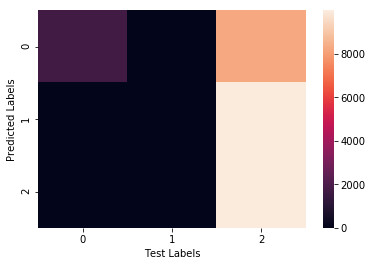

In [306]:
import seaborn as sns
import numpy
import matplotlib.pyplot as plt
xcm=confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
xcm=numpy.array(xcm)
ax = sns.heatmap(xcm)
plt.xlabel('Test Labels')
plt.ylabel('Predicted Labels')
#plt.show()
plt.savefig('ConfusionMatrix')

## Testing Accuracy of Naive Bayes

In [307]:
## Naive Bayes
from sklearn.naive_bayes import GaussianNB
#nb = cross_val_score(MultinomialNB(), X_new, y,cv=3)
#print("Naive Bayes average accuracy : ",nb.mean())
clf = GaussianNB().fit(hiddens, y)
y_pred_nb = clf.predict(np.array(X_new_test))
print('Accuracy of Naive Bayes classifier on test set: {:.2f}'.format(clf.score(np.array(X_new_test), y_test)))

Accuracy of Naive Bayes classifier on test set: 0.33


## Testing Accuracy of Extra Trees

In [174]:
extra_tree = ExtraTreesClassifier().fit(hiddens, y)
y_pred_et = extra_tree.predict(np.array(X_new_test))
print('Accuracy of Extra Tree classifier on test set: {:.2f}'.format(extra_tree.score(np.array(X_new_test), y_test)))

Accuracy of Extra Tree classifier on test set: 0.33


## Testing Accuracy of Random Forest

In [175]:
rf = RandomForestClassifier().fit(hiddens, y)
y_pred_et = extra_tree.predict(np.array(X_new_test))
print('Accuracy of Random Forest classifier on test set: {:.2f}'.format(rf.score(X_new_test, y_test)))

Accuracy of Random Forest classifier on test set: 0.33


## RNN Model For Character Level

In [ ]:
class Net(nn.Module):
    def __init__(self, features, cls_size):
        super(Net, self).__init__()
        self.hidden_size = 256
        self.embedding = nn.Embedding(features, self.hidden_size)
        self.rnn1 = nn.GRU(input_size=features,
                            hidden_size=self.hidden_size)
        self.dense1 = nn.Linear(self.hidden_size, cls_size)

    def forward(self, x, hidden):
        output, hidden = self.rnn1(x, hidden)
        #output = self.dense1(output)
        return output, hidden

    def init_hidden(self, batch_size=1):
        weight = next(self.parameters()).data
        return Variable(weight.new(1, batch_size, self.hidden_size).zero_())

def var(x):
    x = Variable(x)
    return x

embed = nn.Embedding(256, 50)    
embed_optimizer = optim.SGD(embed.parameters(), lr=0.005)

model = Net(features=50, cls_size=256)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
hiddens=[]
y=[]
rnn = model

## Train RNN Model on char level

In [ ]:
def train():
    hiddenCounter=0
    model.train()
    batch_size = 1
    hidden_init = model.init_hidden(1)
    loss_avg = 0
    t0=time.time()
    for s in range(traindata.shape[0]):
        model.zero_grad()
        embed_optimizer.zero_grad()
        hidden = hidden_init
        loss =0
        tweet=traindata.loc[s].tweet
        emb = tokenize(tweet)
        embLen=len(emb)
        if (embLen>1):
            for i in range(embLen): 
                character1=Variable((torch.Tensor([emb[i]])).long())
                character1=embed(character1)
                character1=character1.view(1,1,50)

                output, hidden = model(character1, var(hidden.data))
                output=output.view(1,256)

                if i+1 < embLen: 
                    character2=Variable((torch.Tensor([emb[i+1]])).long())
                    loss += criterion(output, character2)
            #print (loss)
            loss.backward()
            tempHidden=hidden.view(256)
            tempHidden=list(tempHidden.data.numpy())
            hiddens.append(tempHidden)
            y.append(traindata['class'].loc[s])
            hidden_init = copy_state(hidden)
            optimizer.step()
            embed_optimizer.step()
            loss_avg = .99*loss_avg + .01*loss.data[0]/embLen

        if s % 10000 == 0:
            print(epoch, s, loss_avg)
            print (str(s)+' iterations ran, ''time elapsed= '+str((time.time()-t0)/60))

for epoch in range(1):
    print(model.parameters())
    hiddens=[]
    train()

## Test RNN on char level

In [ ]:
testHiddens=[]
testY=[]

def test():
    loaded_model.eval()
    batch_size = 1
    hidden_init = loaded_model.init_hidden(1)
    loss_avg = 0
    t0=time.time()
    for s in range(testdata.shape[0]):
        hidden = hidden_init
        loss =0
        tweet=testdata.loc[s].tweet
        emb = tokenize(tweet)
        embLen=len(emb)
        if (embLen>1):
            for i in range(embLen): 
                character1=Variable((torch.Tensor([emb[i]])).long())
                character1=embed(character1)
                character1=character1.view(1,1,50)

                output, hidden = loaded_model(character1, var(hidden.data))
                output=output.view(1,256)

                if i+1 < embLen: 
                    character2=Variable((torch.Tensor([emb[i+1]])).long())
                    loss += criterion(output, character2)
            #print (loss)
            tempHidden=hidden.view(256)
            tempHidden=list(tempHidden.data.numpy())
            testHiddens.append(tempHidden)
            testY.append(testdata['class'].loc[s])
            hidden_init = copy_state(hidden)
            loss_avg = .99*loss_avg + .01*loss.data[0]/embLen
            
            

for epoch in range(1):
    print(loaded_model.parameters())
    testHiddens=[]
    test()

## Visualize Classification of Characters

In [ ]:
def visualize(data):
    hiddenCounter=0
    loaded_model.eval()
    batch_size = 1
    hidden_init = loaded_model.init_hidden(1)
    loss_avg = 0
    for s in range(1):

        hidden = hidden_init
        loss =0
        tweet=data
        chars=list(tweet)
        emb = tokenize(tweet)
        embLen=len(emb)
        for i in range(embLen): 
            character1=Variable((torch.Tensor([emb[i]])).long())
            letter=character1.data.numpy()
            character1=embed(character1)
            character1=character1.view(1,1,50)
            output, hidden = loaded_model(character1, var(hidden.data))
            
            temp=hidden.view(256)
            temp = temp.data.numpy()
            temp = temp.reshape(1,-1)
            #scales=logreg.predict_proba(temp)
            label=forest.predict(temp)
            if label==0: #control - green 
                text="\033[0;30;42m "+chars[i]
                print (text, end=" ")
            if label==1: #depressed - red
                text="\033[1;30;41m "+chars[i]
                print (text, end=" ")
            if label==2: #ptsd-blue
                text="\033[1;30;44m "+chars[i]
                print (text, end=" ")
            
            output=output.view(1,256)

            if i+1 < embLen: 
                character2=Variable((torch.Tensor([emb[i+1]])).long())
                loss += criterion(output, character2)

        hidden_init = copy_state(hidden)
        loss_avg = .99*loss_avg + .01*loss.data[0]/embLen
        
visualize('i do not want to be alive anymore')